# Identify Handwritten Digits

Here we attempt to classify handwritten digits using two methods, namely Logistic Regression and Support Vector Machine. In order to test the robustness of the methods, I train and test on both the Digits data provided in class and the MNIST data from the homework set.

The training method and encoding are given below. The main idea is to convert the image into a vector of pixels, intensity 0 to 255, and to convert the label to a 'yes/no' vector, eg. 1 = [0,1,0,0,...,0]. Once this is done, training using the One Versus All method, whereby the algorithm is first trained on whether something is or isn't a zero, then a one, then a two, and so forth. Using this approach, gradient descent is then used to minimize the chosen loss function. 

Further details are given below.

### One-hot-encoder

We merely convert a label 0,1,2,... to a binary vector to identify the label. For example,

Label 0 -> [1 0 0 ... 0]

Label 1 -> [0 1 0 ... 0]

etc

### One versus All (OVA) Method

If you have three classes, L1, L2, L3, split it into two groups: L1,L2=L, with L3=L3. Then you have L and L3. Classify and train the model in L vs L3. Repeat for each of the remaining L2, L3 as the individual class. Applying the One-Hot-Encoder, we can use the OVA approach to train by singling out one column at a time, eg. is it a zero? is it a one?, with 1 being a yes and 0 a no.


### Predictor Functions

Logistic Loss:

$p_c(x) = \sigma(c^Tx) = 1.0/(1+exp(c^TX))$

Support Vector Machine:

$p_c(x) = c^Tx$

### Loss Function

Logistic Loss:

L$(x) = -y log(p_c(x)) - (1-y) log(p_c(x))$

Support Vector Machine:

L$(x)= \sqrt{\sum_jc_j^2} + \lambda\sum_mmax(0,1-y_m c^T K(X_m))$

### Gradient Descent

$c_i = c_i - \alpha\frac{\delta L}{\delta c_i}$

In Logistic Loss:

$\frac{\delta L}{\delta c_i} = (P_c(x) - y_i)X_i$

In Support Vector Machine:

$\frac{\delta L}{\delta c_i} = \frac{c_i}{\sqrt{\sum_jc_j^2}} + \lambda\sum_m\frac{\delta}{\delta c_i}max(0,1-y_m c^T K(X_m))$

## Function and Class Definition

### Import the data

In [1]:
import pandas as pd
import numpy as np

def read_dataset(feature_file, label_file):
    '''Read data set in *.csv format to dataframe in Pandas'''
    df_X = pd.read_csv(feature_file)
    df_Y = pd.read_csv(label_file)
    X = df_X.values #convert values in dataframe to np array
    y = df_Y.values
    return X,y

def load_dataset(file_id):
    #folder='data/' #data folder name
    folder=''

    #specify X.vs.Y and Train.vs.Test
    xtr_name = folder+file_id+'_X_train.csv'
    ytr_name = folder+file_id+'_y_train.csv'
    xte_name = folder+file_id+'_X_test.csv'
    yte_name = folder+file_id+'_y_test.csv'

    X_train,y_train = read_dataset(xtr_name,ytr_name)
    X_test,y_test = read_dataset(xte_name,yte_name)

    return X_train,y_train,X_test,y_test

### Normalization, add a column of ones, and label conversion

In [2]:
##########################
##   To allow for c_0   ##
##########################

def add_one_column(X):
    X = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X),1)
    return X

##########################
## Account for variable ##
##  parameter scales    ##
##########################

def normalize_features(X_train,X_test):
    X_train_norm = np.zeros(np.shape(X_train))
    X_test_norm = np.zeros(np.shape(X_test))
    
    count = np.size(X_train[0])
    mean = np.zeros(count)
    std = np.zeros(count)
    
    for i in range(count):
        mean[i] = np.mean(X_train[:,i])
        std[i] = np.std(X_train[:,i])
        if(std[i]!=0):
            X_train_norm[:,i] = (X_train[:,i] - mean[i])/std[i]
            X_test_norm[:,i] = (X_test[:,i] - mean[i])/std[i]
        else:
            X_train_norm[:,i] = (X_train[:,i] - mean[i])
            X_test_norm[:,i] = (X_test[:,i] - mean[i])

    return X_train_norm, X_test_norm

##########################
## Convert labels to    ##
##   yes/no vectors for ##
##   OVA training       ##
##########################

def one_hot_encoder(y_train,y_test):
    #convert label to a vector under one-hot-code fashion
    ohe_max = max(np.max(y_train),np.max(y_test))
    ohe_min = min(np.min(y_train),np.min(y_test))
    y_train_ohe = np.zeros((y_train.size,ohe_max-ohe_min+1))
    y_test_ohe = np.zeros((y_test.size,ohe_max-ohe_min+1))
    for i in range(np.size(y_train)):
        index = y_train[i]
        y_train_ohe[i][int(index-ohe_min)] = 1

    for i in range(np.size(y_test)):
        index = y_test[i]
        y_test_ohe[i][int(index-ohe_min)] = 1
    return y_train_ohe, y_test_ohe

##########################
##  Load, form, label   ##  
##    data all in one   ##
##########################

def load_and_massage(file_id):
    #folder='data/' #data folder name
    #file_id='Digits' #data file_id
    folder=''

    #specify X.vs.Y and Train.vs.Test
    xtr_name = folder+file_id+'_X_train.csv'
    ytr_name = folder+file_id+'_y_train.csv'
    xte_name = folder+file_id+'_X_test.csv'
    yte_name = folder+file_id+'_y_test.csv'

    X_train,y_train = read_dataset(xtr_name,ytr_name)
    X_test,y_test = read_dataset(xte_name,yte_name)

    X_train_norm, X_test_norm = normalize_features(X_train,X_test)
    X_train_norm = add_one_column(X_train_norm)
    X_test_norm = add_one_column(X_test_norm)

    y_train_ohe, y_test_ohe = one_hot_encoder(y_train,y_test)
    
    return X_train_norm, y_train, y_train_ohe, X_test_norm, y_test, y_test_ohe

### Function calls for predictor, Kernels, and Loss Functions

In [3]:
##########################
##        Functions     ##
##########################

def sigmoid(X,c):
    return 1.0/(1.0 + np.exp(-X.dot(c)))

def dot(X,c):
    return X.dot(c)

DFunction = {'sigmoid':sigmoid,'dot':dot}

##########################
##        Kernels       ##
##########################

def linear_kernel(xi,X=None):
    return xi

DKernel = {'linear':linear_kernel}

##########################
##    Loss Functions    ##
##########################

def logistic_loss(y,yhat,X,c,reg_param,kernel,M=None):
    return (-y.T.dot(np.log(yhat)) - (1.0 - y).T.dot(np.log(1.0 - yhat)))/float(len(y))

def logistic_gradient(y,yhat,X,c,reg_param,kernel,M=None):
    return X.T.dot(yhat-y)/float(len(y))

def svm_loss(y,yhat,X,c,reg_param,kernel,M=None):
    loss=0
    kern = kernel(X,M)
    hinge = 1 - y*c.T.dot(kern.T).T
    for elem in hinge:
        if(elem>0):
            loss += elem
    loss = loss*reg_param
    loss += np.sqrt(sum(c*c))
    return loss

def svm_gradient(y,yhat,X,c,reg_param,kernel,M=None):
    grad = np.zeros(np.shape(c))
    kern = kernel(X,M)
    hinge = 1 - y*c.T.dot(kern.T).T
    for i in range(hinge.size):
        if(hinge[i]>0):
            grad += (-y[i]*kern[i,:].T).reshape(-1,1)
    grad = grad*reg_param
    if(c.all()!=0):
        grad += c/np.sqrt(sum(c*c))
    return grad

DLoss={'logistic':logistic_loss,'support vector machine':svm_loss}
DOptimizer={'logistic':logistic_gradient,'support vector machine':svm_gradient}

### Prediction and Testing Functions

In [4]:
##########################
##        Functions     ##
##########################

def gradient_descent(X,y,c,cpredictor,closs,epochs,learning_rate,reg_param):
    y = y.reshape(-1,1) #convert y to a matrix nx1
    loss_history = [0]*epochs 
    for epoch in range(epochs):
        yhat = cpredictor.predictor(X,c)
        loss_history[epoch] = closs.loss(y,yhat,X,c,reg_param,cpredictor.kernel).ravel()
        grad = closs.gradient(y,yhat,X,c,reg_param,cpredictor.kernel)
        #updating coeffs upon the gradient change
        c = c - learning_rate*grad
    return c, loss_history

def binary_train(X,y,cpredictor,closs,epochs,learning_rate,reg_param):
    #Training our model based on the training data
    #    Input:   X_train: input features
    #             y_train: binary labels
    #    Return:  coeffs of the logistic model
        
    coeffs_0 = np.zeros((X.shape[1],1))
    coeffs_grad, history_loss = gradient_descent(X,y,coeffs_0,cpredictor,closs,epochs,learning_rate,reg_param)
  
    return coeffs_grad, history_loss

def OVA_train(X,y,cpredictor,closs,epochs,learning_rate,reg_param): # y_train: one_hot_encoder labels, 10 columns
    #Loop over the label columns such that
    #    0 0 1                   0th: 0   1st:  0    2nd:  1
    #    1 0 0  -- trains as -->      1         0          0
    #    1 0 0                        1         0          0
    #
    weights = []
    history = []
    for i in range(y.shape[1]): #10 columns
        y_train_one_column = y[:,i] #pick ith column
        #run training
        weights_one_column, loss_history = binary_train(X, y_train_one_column,cpredictor,closs,epochs,learning_rate,reg_param)
        weights.append(weights_one_column)
        history.append(loss_history)
    return weights, history

def prediction(weights_list,X,cpredictor):
    i = 0
    for weights in weights_list:
        decision_one_column = cpredictor.predictor(X,weights)
        #probability of one column
        if i==0:
            decision_matrix = decision_one_column
        else:
            #combine all decision columns to form a matrix
            decision_matrix = np.concatenate((decision_matrix, decision_one_column),axis=1)
        i+=1

    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    num_test_samples = X.shape[0]
    #find which index gives us the highest probability
    ypred = np.zeros(num_test_samples, dtype=int)
    for i in range(num_test_samples):
        ypred[i] = labels[np.argmax(decision_matrix[i,:])]
    return ypred

def accuracy(weights_list,X,y,cpredictor):
    acc=0
    for index in range(len(y)):
        #Use the model to predict thenumber in the image X_test[20]
        ypred = prediction(weights_list, X[index:index+1],cpredictor)
        if(ypred==y[index]):
            acc+=1
    return 100*acc/float(len(y))

#Use for scikit learn predictions
def accur(y,yhat):
    acc=0
    for index in range(len(y)):
        if(y[index]==yhat[index]):
            acc+=1
    acc*=100/len(y)
    return acc

DTrain={'one over all':OVA_train}

### Libraries

Feed the DLibrary, a compilation of all necessary libraries, to the CLearn class so your choice may be easily executed. Note that in the code's current form really only the two collections for 'logistic' and 'svm' may be chosen, but in future updates the code could be made more flexible. 

In [5]:
DFunction = {'sigmoid':sigmoid,'dot':dot}
DKernel = {'linear':linear_kernel}
DLoss={'logistic':logistic_loss,'support vector machine':svm_loss}
DOptimizer={'logistic':logistic_gradient,'support vector machine':svm_gradient}
DTrain={'one over all':OVA_train}
DLibrary={'Function':DFunction,'Kernel':DKernel,'Loss':DLoss,'Optimizer':DOptimizer,'Train':DTrain,'Train':DTrain}

### Prediction and Testing Classes

These classes accept libraries and keys to select how they operate. Create a "CLearn" class and feed it the DLibrary from above. An example of DKey selection is given during calculation.

In [6]:
class CPredictor:
    def __init__(self,DFunction,DKernel):
        self.DFunction = DFunction
        self.DKernel = DKernel
        
    def Set_Function(self,FKey):
        if FKey in self.DFunction:
            self.function=DFunction[FKey]
        else:
            print('Invalid Fkey.',FKey,'not found in loaded Function Dictionary.')
    def Set_Kernel(self,KKey):
        if KKey in self.DKernel:
            self.kernel=DKernel[KKey]
        else:
            print('Invalid Kkey.',KKey,'not found in loaded Kernel Dictionary.')
    def Set_Keys(self,FKey,KKey):
        self.Set_Function(FKey)
        self.Set_Kernel(KKey)
        
    def predictor(self,X,c,M=None):
        return self.function(self.kernel(X,M),c)

class CLoss:
    def __init__(self,DLoss,DOptimizer):
        self.DLoss = DLoss
        self.DOptimizer = DOptimizer

    def Set_Loss(self,LKey):
        if LKey in self.DLoss:
            self.Loss = self.DLoss[LKey]
        else:
            print('Invalid LKey.',LKey,'not found in loaded Loss Dictionary.')
    def Set_Optimizer(self,OKey):
        if OKey in self.DOptimizer:
            self.Optimizer = self.DOptimizer[OKey]
        else:
            print('Invalid OKey.',OKey,'not found in loaded Optimizer Dictionary.')
    def Set_Keys(self,LKey,OKey):
        self.Set_Loss(LKey)
        self.Set_Optimizer(OKey)

    def loss(self,y,yhat,X,c,reg_param,kernel,M=None):
        return self.Loss(y,yhat,X,c,reg_param,kernel,M)

    def gradient(self,y,yhat,X,c,reg_param,kernel,M=None):
        return self.Optimizer(y,yhat,X,c,reg_param,kernel,M)

class CTrain:
    def __init__(self,DLibrary,DKey):
        self.DLibrary=DLibrary
        self.DTrain=DLibrary['Train']
        self.Predictor = CPredictor(self.DLibrary['Function'],self.DLibrary['Kernel'])
        self.Loss = CLoss(self.DLibrary['Loss'],self.DLibrary['Optimizer'])
        self.Set_Keys(DKeys)

    def Set_Predictor(self,FKey,KKey):
        self.Predictor.Set_Keys(FKey,KKey)
    def Set_Loss(self,LKey,OKey):
        self.Loss.Set_Keys(LKey,OKey)
    def Set_Keys(self,DKey):
        self.DKey=DKey
        self.Set_Predictor(DKey['F'],DKey['K'])
        self.Set_Loss(DKey['L'],DKey['O'])
        self.Set_Train(DKey['T'])
    def Set_Train(self,TKey):
        if TKey in DTrain:
            self.Train=self.DTrain[TKey]
        else:
            print('Invalid TKey.',TKey,'not found in loaded Train Dictionary.')

    def train(self,X,y,DParameter):
        return self.Train(X,y,self.Predictor,self.Loss,DParameter['Epochs'],DParameter['Learning_rate'],DParameter['Reg_param'])

class CLearn:
    def __init__(self,DLibrary,DParameter,DKey):
        self.DLibrary=DLibrary
        self.DParameter=DParameter
        self.Trainer=CTrain(self.DLibrary,DKey)
        
    def Set_Keys(self,DKey):
        self.Trainer.Set_Keys(DKey)    
    def Set_Param(self,DParameter):
        self.DParameter=DParameter
    def Train(self,X,y):
        self.Weights_list, self.History = self.Trainer.train(X,y,self.DParameter)
        
    def predict(self,X):
        return prediction(self.Weights_list,X,self.Trainer.Predictor)
    def accuracy(self,X,y):
        return accuracy(self.Weights_list,X,y,self.Trainer.Predictor)

### Plotting Functions

Plot_digit and plot_test can be used to see by eye how well the classes predict the test data. Select a range, index1 to index2, over which to test a customized and trained CLearn class. A label, prediction, and image will print for each element in the range.

Plot_loss is antiquated but kept for completeness.

Plot_history will plot a loss history from training a model.

Print_journal will print an overview of of training a model, including accuracy, parameters, a full prediction set, and a loss history. These are returned by "Run" and "Run_and_Print" defined below.

In [9]:
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

def plot_digit(feature_vector):
    dim = int(np.sqrt(len(feature_vector)))
    plt.gray()
    plt.matshow(feature_vector.reshape(dim,dim))
    plt.show()

def plot_test(index1,index2,Clearn,X_test,X_test_norm,y_test):
    for index in range(index1,index2):
        print('Image:',index)
        plot_digit(X_test[index])
        ypred = Clearn.predict(X_test_norm[index].reshape(1,-1))
        print('Label:', int(y_test[index]))
        print('Prediction:',int(ypred))
        print('')

def plot_loss(loss):
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.show()
    
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('# of epochs')
    i=0
    for elem in history:
        print(i)
        i+=1
        plt.plot(elem)
        plt.show()
        
def print_journal(journal,index):
    acc = journal[index][0]
    epochs = journal[index][1]
    learning_rate = journal[index][2]
    reg_param = journal[index][3]
    pred = journal[index][4]
    history = journal[index][5].History

    print('Epochs:',epochs,'\nLR:',learning_rate,'\nRG:',reg_param)
    print('  Accuracy: ',acc,'%')
    print(pred)
    plot_history(history)


### Run functions

These functions return a training journal list from training the model. Give it the full DLibrary, a set of sets of parameters, DParam, over which to train, a set of DKeys to select which model is to be used, and a file_id for which data to load. 'Run' merely prints that training has begun and finished. 'Run_and_Print' will give model parameters and accuracy as each parameter set is trained and tested. Each function records a journal for each parameter set during the training process.

In [10]:
def Run(DLibrary,DParam,DKeys,file_id):
    X_train_norm, y_train, y_train_ohe,\
        X_test_norm, y_test, y_test_ohe\
            = load_and_massage(file_id)
    print('Running',DKeys['L'],'on:',file_id)
    i=0
    journal=[]
    epochs=DParam['Epochs']
    LR=DParam['LR']
    RP=DParam['RP']
    for learning_rate in LR:
        for reg_param in RP:
            DParam={'Epochs':epochs,'Learning_rate':learning_rate,'Reg_param':reg_param}
            learn = CLearn(DLibrary,DParam,DKeys)
            i+=1
            learn.Train(X_train_norm,y_train_ohe)
            acc = learn.accuracy(X_test_norm, y_test) 
            pred = learn.predict(X_test_norm)
            journal.append((acc,epochs,learning_rate,reg_param,pred,learn))
    print('Finished.')
    return journal

def Run_and_Print(DLibrary,DParam,DKeys,file_id):
    X_train_norm, y_train, y_train_ohe,\
        X_test_norm, y_test, y_test_ohe\
            = load_and_massage(file_id)
    print('Running',DKeys['L'],'on:',file_id,'\n----------------------------')
    i=0
    journal=[]
    epochs=DParam['Epochs']
    LR=DParam['LR']
    RP=DParam['RP']
    for learning_rate in LR:
        for reg_param in RP:
            DParam={'Epochs':epochs,'Learning_rate':learning_rate,'Reg_param':reg_param}
            learn = CLearn(DLibrary,DParam,DKeys)
            i+=1
            print('Training...',i,'of',len(LR)*len(RP),'...')
            print('   Epochs:',epochs,'\n   LR:',learning_rate,'\n   RP:',reg_param)
            learn.Train(X_train_norm,y_train_ohe)
            print('Testing...')
            acc = learn.accuracy(X_test_norm, y_test) 
            print('Accuracy: ',acc,'%')
            pred = learn.predict(X_test_norm)
            print('')
            journal.append((acc,epochs,learning_rate,reg_param,pred,learn))
    print('Finished.')
    return journal

# Conduct Data Analysis

Note: loss history occasionally has problems which appear has division by zero. It does not affect the training itself.

The training is organized so that each cell loops over the given parameter sets. Currently, they are set to run without printing progress. To change this, uncomment the 'Run_and_Print' and comment the 'Run.'

### Run
Here we test each model on a range of parameters. To use the 'Run' function and therefore use the CLearn class, select the desired parameters:

file_id selects whether to train on the Digits or MNIST data.

DKeys selects which model is to be used. Currently, the only combinations which will definitely work are given below in 'Logistic Training' and 'SVM Training.'

DParam is actually a set of sets of parameters. 'epochs' is uniform across training sets, but 'LR' (Learning Rate) and 'RP' (Regularization Parameter) will both be looped over. Note that for Logisitic training I define RP=[-1], a dummy parameter, to denote that it is not being used, but still requires an entry.

The functions then return a journal list, which each entry is a journal for the current training parameter set. A Journal includes, accuracy, epochs, learning rate, reg param, prediction vector, and loss history, in that order. See where each is appended to the journal in the 'Run' functions.

### Libraries

Use for selecting which model is used for training.

In [11]:
DFunction = {'sigmoid':sigmoid,'dot':dot}
DKernel = {'linear':linear_kernel}
DLoss={'logistic':logistic_loss,'support vector machine':svm_loss}
DOptimizer={'logistic':logistic_gradient,'support vector machine':svm_gradient}
DTrain={'one over all':OVA_train}
DLibrary={'Function':DFunction,'Kernel':DKernel,'Loss':DLoss,'Optimizer':DOptimizer,'Train':DTrain,'Train':DTrain}

### Scikit Learn

For sake of comparison

In [12]:
from sklearn.svm import LinearSVC
clf = LinearSVC(loss='hinge',max_iter=5000)

file_id='Digits'
X_train_norm, y_train, y_train_ohe, X_test_norm, y_test, y_test_ohe = load_and_massage(file_id)
clf.fit(X_train_norm,y_train.ravel())
ypred=clf.predict(X_test_norm)
print('ScikitLearn SVC on',file_id,':',accur(y_test,ypred),'%')


file_id='MNIST'
X_train_norm, y_train, y_train_ohe, X_test_norm, y_test, y_test_ohe = load_and_massage(file_id)
clf.fit(X_train_norm,y_train.ravel())
ypred=clf.predict(X_test_norm)
print('ScikitLearn SVC on',file_id,':',accur(y_test,ypred),'%')

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ScikitLearn SVC on Digits : 94.44444444444444 %
ScikitLearn SVC on MNIST : 81.4 %


### Digits Data

To see the parameters and accuracy, uncomment run_and_print and comment run. To run both will be redundant. 

Here for logistic we train across learning rates ranging from 1.0 to 10.0 to examine a range of parameters. After testing, it seems the maximum occurs within this range, since the rates lower than 1 and higher than 12 begin to decrease accuracy. The maximum accuracy model is extracted later in the notebook. It seems likely that for those much smaller the code will need far too many epochs to be reasonably run in a demonstration, and for those much bigger the code is unable to approach the maximum because the steps will be too large. It seems to settle into 96.0% accuracy well around a learning rate of 7-10, though the loss history encounters issues.

For the SVM we training over a grid of LR and RP, from 0.008 to 0.012, in search of the maximum. 

In [13]:
##########################
##  Logistic Training   ##
##########################
file_id='Digits'
DKeys=\
    {'F':'sigmoid',\
     'K':'linear',\
     'L':'logistic',\
     'O':'logistic',\
     'T':'one over all'}

epochs=500
LR=[1.0,5.0,7.0,8.0,10.0]
RP=[-1]
DParam=\
    {'Epochs':epochs,\
     'LR':LR,\
     'RP':RP}

#ld_journal = Run(DLibrary,DParam,DKeys,file_id)
ld_journal = Run_and_Print(DLibrary,DParam,DKeys,file_id)

Running logistic on: Digits 
----------------------------
Training... 1 of 5 ...
   Epochs: 500 
   LR: 1.0 
   RP: -1
Testing...
Accuracy:  94.88888888888889 %

Training... 2 of 5 ...
   Epochs: 500 
   LR: 5.0 
   RP: -1
Testing...
Accuracy:  95.55555555555556 %

Training... 3 of 5 ...
   Epochs: 500 
   LR: 7.0 
   RP: -1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Testing...
Accuracy:  95.77777777777777 %

Training... 4 of 5 ...
   Epochs: 500 
   LR: 8.0 
   RP: -1
Testing...
Accuracy:  96.0 %

Training... 5 of 5 ...
   Epochs: 500 
   LR: 10.0 
   RP: -1
Testing...
Accuracy:  96.0 %

Finished.


In [14]:
##########################
##     SVM Training     ##
##########################
file_id='Digits'
DKeys=\
    {'F':'dot',\
     'K':'linear',\
     'L':'support vector machine',\
     'O':'support vector machine',\
     'T':'one over all'}

epochs=10
LR=[0.008,0.01,0.012]
RP=[0.008,0.01,0.012]
DParam=\
    {'Epochs':epochs,\
     'LR':LR,\
     'RP':RP}

#sd_journal = Run(DLibrary,DParam,DKeys,file_id)
sd_journal = Run_and_Print(DLibrary,DParam,DKeys,file_id)

Running support vector machine on: Digits 
----------------------------
Training... 1 of 9 ...
   Epochs: 10 
   LR: 0.008 
   RP: 0.008
Testing...
Accuracy:  87.77777777777777 %

Training... 2 of 9 ...
   Epochs: 10 
   LR: 0.008 
   RP: 0.01
Testing...
Accuracy:  88.44444444444444 %

Training... 3 of 9 ...
   Epochs: 10 
   LR: 0.008 
   RP: 0.012
Testing...
Accuracy:  89.11111111111111 %

Training... 4 of 9 ...
   Epochs: 10 
   LR: 0.01 
   RP: 0.008
Testing...
Accuracy:  88.44444444444444 %

Training... 5 of 9 ...
   Epochs: 10 
   LR: 0.01 
   RP: 0.01
Testing...
Accuracy:  89.77777777777777 %

Training... 6 of 9 ...
   Epochs: 10 
   LR: 0.01 
   RP: 0.012
Testing...
Accuracy:  89.55555555555556 %

Training... 7 of 9 ...
   Epochs: 10 
   LR: 0.012 
   RP: 0.008
Testing...
Accuracy:  89.11111111111111 %

Training... 8 of 9 ...
   Epochs: 10 
   LR: 0.012 
   RP: 0.01
Testing...
Accuracy:  89.55555555555556 %

Training... 9 of 9 ...
   Epochs: 10 
   LR: 0.012 
   RP: 0.012
Testi

### MNIST Data

In [15]:
##########################
##   MNIST Training    ##
##########################
file_id='MNIST'
DKeys=\
    {'F':'sigmoid',\
     'K':'linear',\
     'L':'logistic',\
     'O':'logistic',\
     'T':'one over all'}

epochs=500
LR=[0.03,0.05,0.1,0.5]
RP=[-1]
DParam=\
    {'Epochs':epochs,\
     'LR':LR,\
     'RP':RP}

#lm_journal = Run(DLibrary,DParam,DKeys,file_id)
lm_journal = Run_and_Print(DLibrary,DParam,DKeys,file_id)

Running logistic on: MNIST 
----------------------------
Training... 1 of 4 ...
   Epochs: 500 
   LR: 0.03 
   RP: -1
Testing...
Accuracy:  86.8 %

Training... 2 of 4 ...
   Epochs: 500 
   LR: 0.05 
   RP: -1
Testing...
Accuracy:  87.8 %

Training... 3 of 4 ...
   Epochs: 500 
   LR: 0.1 
   RP: -1
Testing...
Accuracy:  87.4 %

Training... 4 of 4 ...
   Epochs: 500 
   LR: 0.5 
   RP: -1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Testing...
Accuracy:  87.4 %

Finished.


In [16]:
##########################
##   MNIST Training    ##
##########################
file_id='MNIST'
DKeys=\
    {'F':'dot',\
     'K':'linear',\
     'L':'support vector machine',\
     'O':'support vector machine',\
     'T':'one over all'}

epochs=20
LR=[0.001,0.0012,0.0014]
RP=[0.01,0.012,0.014]
DParam=\
    {'Epochs':epochs,\
     'LR':LR,\
     'RP':RP}

#sm_journal = Run(DLibrary,DParam,DKeys,file_id)
sm_journal = Run_and_Print(DLibrary,DParam,DKeys,file_id)

Running support vector machine on: MNIST 
----------------------------
Training... 1 of 9 ...
   Epochs: 20 
   LR: 0.001 
   RP: 0.01
Testing...
Accuracy:  87.8 %

Training... 2 of 9 ...
   Epochs: 20 
   LR: 0.001 
   RP: 0.012
Testing...
Accuracy:  87.8 %

Training... 3 of 9 ...
   Epochs: 20 
   LR: 0.001 
   RP: 0.014
Testing...
Accuracy:  88.0 %

Training... 4 of 9 ...
   Epochs: 20 
   LR: 0.0012 
   RP: 0.01
Testing...
Accuracy:  87.8 %

Training... 5 of 9 ...
   Epochs: 20 
   LR: 0.0012 
   RP: 0.012
Testing...
Accuracy:  88.0 %

Training... 6 of 9 ...
   Epochs: 20 
   LR: 0.0012 
   RP: 0.014
Testing...
Accuracy:  87.8 %

Training... 7 of 9 ...
   Epochs: 20 
   LR: 0.0014 
   RP: 0.01
Testing...
Accuracy:  88.0 %

Training... 8 of 9 ...
   Epochs: 20 
   LR: 0.0014 
   RP: 0.012
Testing...
Accuracy:  87.8 %

Training... 9 of 9 ...
   Epochs: 20 
   LR: 0.0014 
   RP: 0.014
Testing...
Accuracy:  87.6 %

Finished.


## Prediction Comparison

In [17]:
def y_comparison(y_test,log_pred,svm_pred):
    print('i   y log svm')
    print('-------------')
    for i in range(len(y_test)):
        y=y_test[i]
        l=log_pred[i]
        s=svm_pred[i]
        if(y!=l or y!=s or l!=s):
            print(i,'',y_test[i],log_pred[i],svm_pred[i])

def tally(y_test,log_pred,svm_pred):
    total=np.zeros(10)
    tal=[np.zeros(10),np.zeros(10)]
    for i in range(len(y_test)):
        y=y_test[i]
        l=log_pred[i]
        s=svm_pred[i]
        if(y==l):
            tal[0][y]+=1
        if(y==s):
            tal[1][y]+=1
        total[y]+=1
    tal[0]*=100/total
    tal[1]*=100/total
    return tal
def tally_matrix(y_test,pred):
    total=np.zeros(10)
    tal=np.zeros((10,10))
    for i in range(len(y_test)):
        y=int(y_test[i])
        p=int(pred[i])
        tal[y][p]+=1
        total[y]+=1
    for index in range(tal.shape[0]):
        tal[index] *= 100/total[index]
    return tal
        
def tally_matrix_no_diag(y_test,pred):
    total=np.zeros(10)
    tal=np.zeros((10,10))
    for i in range(len(y_test)):
        y=int(y_test[i])
        p=int(pred[i])
        if(y!=p):
            tal[y][p]+=1
        total[y]+=1
    for index in range(tal.shape[0]):
        tal[index] *= 100/total[index]
    return tal

def find_max(history):
    max=-1
    maxi=-1
    for index in range(len(history)):
        if(history[index][0]>max):
            max=history[index][0]
            maxi=index
    return maxi

### Examing the Maximum Accuracy Runs

Maximum accuracy for each model:
max_log dig - trial 3:  96.00
max_svm dig - trial 4:  89.78
max_log mni - trial 1:  87.80
max_svm mni - trial 2:  88.00

Accuracy per digit:
mod: ld       sd      lm      sm
ep:  500       10      500     20
lr:  8.00     0.01    0.05   0.00
rp:           0.01           0.01
dig:
0:   97.78   100.00   95.74   91.49
1:   92.31   82.69   96.83   96.83
2:   100.00   89.80   88.24   90.20
3:   94.23   82.69   79.17   77.08
4:   97.30   94.59   86.36   90.91
5:   100.00   91.43   88.10   88.10
6:   100.00   97.96   94.44   88.89
7:   93.18   97.73   90.32   83.87
8:   89.47   73.68   77.78   86.11
9:   95.92   87.76   75.47   84.91

Each data set and each model has its pitfalls. 

For the low resolution digits data, both models have the largest issues with 8s. This is likely due to the fact that in low resolution the loops blur together and thus cause confusion with 1s, 2s, 3s, 6s, 7s, and 9s. Specific confusions can be further split into mutual or directional, that is 3s may be confused with 8s, but 8s are more rarely confused with 3s. Others, such as 7s and 9s appear to be mutually confused. This is likely due to that a low resolution 3 appears to thicken to an 8, while a blurred 8 appears even thicker and a distinct 3 shape is not inferred. In comparison, 7s and 9s a very similar in shape, low resolution or not, and are separated only by completing the drawn loop. Lastly, an overall trend seems to be that the errors are concentrated and less scattershot, that is there are fewer spots to be seen in the error matrix below.

For the higher resolution MNIST data, the errors appear to be more evenly spread across the entire range of choices, that is there is more gray/white space seen in the error matrix below. General errors are more prevalent with 3s, 7s, 8s. The main mutual errors are concentrated between 3s and 5s, and 7s and 9s.

Overall, the simple logistic model seems to do very well for the low resolution digits data, whereas the svm model struggles and is unable to attain the same accuracy. However, with the higher resolution model, both attain a similar max accuracy around 88%, where 89-90% seem possible with very high epoch counts. However, occasionally high epoch counts result in a drop in accuracy of several percentage points.

Maximum accuracy for each model:
max_log dig - trial 3:  96.00
max_svm dig - trial 4:  89.78
max_log mni - trial 1:  87.80
max_svm mni - trial 2:  88.00

Accuracy per digit:
mod: ld       sd      lm      sm
ep:  500       10      500     20
lr:  8.00     0.01    0.05   0.00
rp:           0.01           0.01
dig:
0:   97.78   100.00   95.74   91.49
1:   92.31   82.69   96.83   96.83
2:   100.00   89.80   88.24   90.20
3:   94.23   82.69   79.17   77.08
4:   97.30   94.59   86.36   90.91
5:   100.00   91.43   88.10   88.10
6:   100.00   97.96   94.44   88.89
7:   93.18   97.73   90.32   83.87
8:   89.47   73.68   77.78   86.11
9:   95.92   87.76   75.47   84.91


Percent of row_num classified as col_num
No Diagonal for Images -- Correctly classified % set to zero
----------------------
classification: row  by column
classification: row=Label by col=Prediction
classification: true by classified

----------------------
LOGISTIC DIGITS


<Figure size 432x288 with 0 Axes>

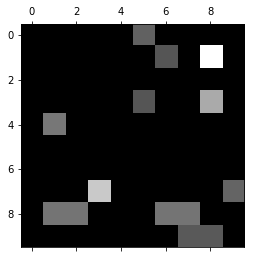

[[ 97.78   0.     0.     0.     0.     2.22   0.     0.     0.     0.  ]
 [  0.    92.31   0.     0.     0.     0.     1.92   0.     5.77   0.  ]
 [  0.     0.   100.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.    94.23   0.     1.92   0.     0.     3.85   0.  ]
 [  0.     2.7    0.     0.    97.3    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.   100.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.   100.     0.     0.     0.  ]
 [  0.     0.     0.     4.55   0.     0.     0.    93.18   0.     2.27]
 [  0.     2.63   2.63   0.     0.     0.     2.63   2.63  89.47   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     2.04   2.04  95.92]]

----------------------
SVM DIGITS


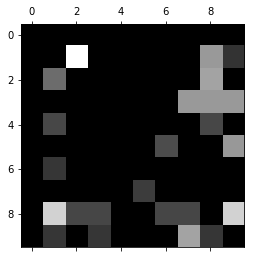

[[100.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.    82.69   9.62   0.     0.     0.     0.     0.     5.77   1.92]
 [  0.     4.08  89.8    0.     0.     0.     0.     0.     6.12   0.  ]
 [  0.     0.     0.    82.69   0.     0.     0.     5.77   5.77   5.77]
 [  0.     2.7    0.     0.    94.59   0.     0.     0.     2.7    0.  ]
 [  0.     0.     0.     0.     0.    91.43   2.86   0.     0.     5.71]
 [  0.     2.04   0.     0.     0.     0.    97.96   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     2.27   0.    97.73   0.     0.  ]
 [  0.     7.89   2.63   2.63   0.     0.     2.63   2.63  73.68   7.89]
 [  0.     2.04   0.     2.04   0.     0.     0.     6.12   2.04  87.76]]

----------------------
LOGISTIC MNIST


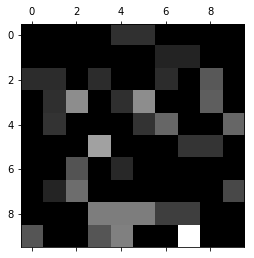

[[95.74  0.    0.    0.    2.13  2.13  0.    0.    0.    0.  ]
 [ 0.   96.83  0.    0.    0.    0.    1.59  1.59  0.    0.  ]
 [ 1.96  1.96 88.24  1.96  0.    0.    1.96  0.    3.92  0.  ]
 [ 0.    2.08  6.25 79.17  2.08  6.25  0.    0.    4.17  0.  ]
 [ 0.    2.27  0.    0.   86.36  2.27  4.55  0.    0.    4.55]
 [ 0.    0.    0.    7.14  0.   88.1   0.    2.38  2.38  0.  ]
 [ 0.    0.    3.7   0.    1.85  0.   94.44  0.    0.    0.  ]
 [ 0.    1.61  4.84  0.    0.    0.    0.   90.32  0.    3.23]
 [ 0.    0.    0.    5.56  5.56  5.56  2.78  2.78 77.78  0.  ]
 [ 3.77  0.    0.    3.77  5.66  0.    0.   11.32  0.   75.47]]

----------------------
SVM MNIST


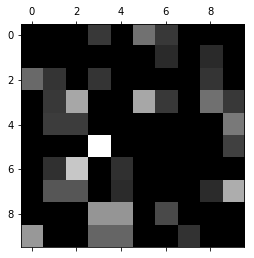

[[91.49  0.    0.    2.13  0.    4.26  2.13  0.    0.    0.  ]
 [ 0.   96.83  0.    0.    0.    0.    1.59  0.    1.59  0.  ]
 [ 3.92  1.96 90.2   1.96  0.    0.    0.    0.    1.96  0.  ]
 [ 0.    2.08  6.25 77.08  0.    6.25  2.08  0.    4.17  2.08]
 [ 0.    2.27  2.27  0.   90.91  0.    0.    0.    0.    4.55]
 [ 0.    0.    0.    9.52  0.   88.1   0.    0.    0.    2.38]
 [ 0.    1.85  7.41  0.    1.85  0.   88.89  0.    0.    0.  ]
 [ 0.    3.23  3.23  0.    1.61  0.    0.   83.87  1.61  6.45]
 [ 0.    0.    0.    5.56  5.56  0.    2.78  0.   86.11  0.  ]
 [ 5.66  0.    0.    3.77  3.77  0.    0.    1.89  0.   84.91]]


In [18]:
####################################
#   Plot the maximum acc of each   #
#    model, the accuracy per digit #
#    and a print out of how digits #
#    were classified.              #
####################################
Xtrd,ytrd,Xted,yted=load_dataset('Digits')
Xtrm,ytrm,Xtem,ytem=load_dataset('MNIST')

max_ld=find_max(ld_journal)
acc_ld=ld_journal[max_ld][0]

max_lm=find_max(lm_journal)
acc_lm=lm_journal[max_lm][0]

max_sd=find_max(sd_journal)
acc_sd=sd_journal[max_sd][0]

max_sm=find_max(sm_journal)
acc_sm=sm_journal[max_sm][0]

print('Maximum accuracy for each model:')
print('max_log dig - trial %d:  %.2f'%(max_ld,acc_ld))
print('max_svm dig - trial %d:  %.2f'%(max_sd,acc_sd))
print('max_log mni - trial %d:  %.2f'%(max_lm,acc_lm))
print('max_svm mni - trial %d:  %.2f'%(max_sm,acc_sm))
print('')

tal_d=tally(yted,ld_journal[max_ld][4],sd_journal[max_sd][4])
tal_m=tally(ytem,lm_journal[max_lm][4],sm_journal[max_sm][4])

print('Accuracy per digit:')
print('mod: ld       sd      lm      sm')
print('ep:  %d       %d      %d     %d'%(ld_journal[max_ld][1],sd_journal[max_sd][1],lm_journal[max_lm][1],sm_journal[max_sm][1]))
print('lr:  %.2f     %.2f    %.2f   %.2f'%(ld_journal[max_ld][2],sd_journal[max_sd][2],lm_journal[max_lm][2],sm_journal[max_sm][2]))
print('rp:           %.2f           %.2f'%(sd_journal[max_sd][3],sm_journal[max_sm][3]))
print('dig:')
for index in range(len(tal_d[0])):
    print("%d:   %.2f   %.2f   %.2f   %.2f"%(index,tal_d[0][index],tal_d[1][index],tal_m[0][index],tal_m[1][index]))

np.set_printoptions(precision=2)
plt.gray()
print('\n')
print('Percent of row_num classified as col_num')
print('No Diagonal for Images -- Correctly classified % set to zero')
print('----------------------')
print('classification: row  by column')
print('classification: row=Label by col=Prediction')
print('classification: true by classified')

print('\n----------------------')
print('LOGISTIC DIGITS')
ld_matrix_nd=tally_matrix_no_diag(yted,ld_journal[max_ld][4])
ld_matrix=tally_matrix(yted,ld_journal[max_ld][4])
plt.matshow(ld_matrix_nd)
plt.show()
print(ld_matrix)

print('\n----------------------')
print('SVM DIGITS')
sd_matrix_nd=tally_matrix_no_diag(yted,sd_journal[max_sd][4])
sd_matrix=tally_matrix(yted,sd_journal[max_sd][4])
plt.matshow(sd_matrix_nd)
plt.show()
print(sd_matrix)

print('\n----------------------')
print('LOGISTIC MNIST')
lm_matrix_nd=tally_matrix_no_diag(ytem,lm_journal[max_lm][4])
lm_matrix=tally_matrix(ytem,lm_journal[max_lm][4])
plt.matshow(lm_matrix_nd)
plt.show()
print(lm_matrix)

print('\n----------------------')
print('SVM MNIST')
sm_matrix_nd=tally_matrix_no_diag(ytem,sm_journal[max_sm][4])
sm_matrix=tally_matrix(ytem,sm_journal[max_sm][4])
plt.matshow(sm_matrix_nd)
plt.show()
print(sm_matrix)

## Plotting the support vector machine program test with images

To visualize the data, uncomment the model you wish to see tested and use index1 and index2 to set the observation range.

Image: 25


<Figure size 432x288 with 0 Axes>

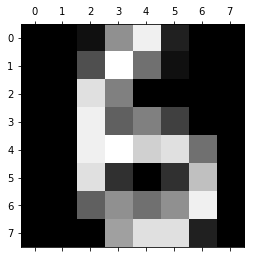

Label: 6
Prediction: 6

Image: 26


<Figure size 432x288 with 0 Axes>

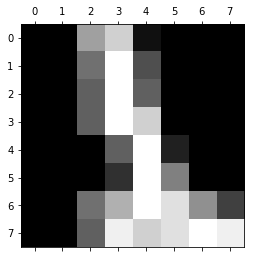

Label: 1
Prediction: 1

Image: 27


<Figure size 432x288 with 0 Axes>

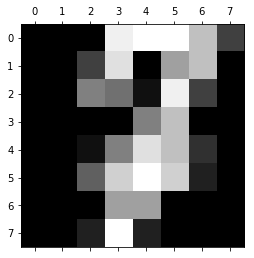

Label: 7
Prediction: 7

Image: 28


<Figure size 432x288 with 0 Axes>

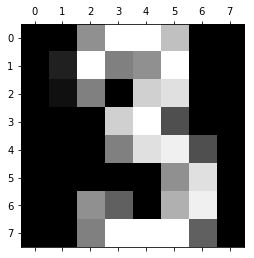

Label: 3
Prediction: 3

Image: 29


<Figure size 432x288 with 0 Axes>

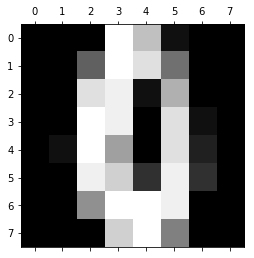

Label: 0
Prediction: 0

Image: 30


<Figure size 432x288 with 0 Axes>

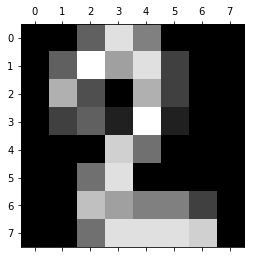

Label: 2
Prediction: 2

Image: 31


<Figure size 432x288 with 0 Axes>

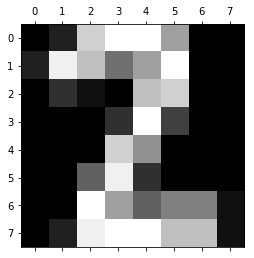

Label: 2
Prediction: 2

Image: 32


<Figure size 432x288 with 0 Axes>

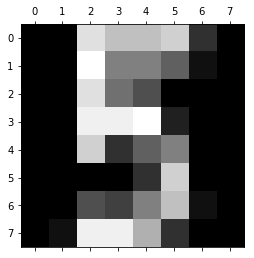

Label: 5
Prediction: 5

Image: 33


<Figure size 432x288 with 0 Axes>

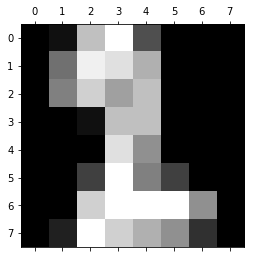

Label: 2
Prediction: 2

Image: 34


<Figure size 432x288 with 0 Axes>

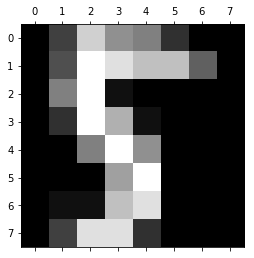

Label: 5
Prediction: 5



In [21]:
#Plot from index1 to index2
index1=25
index2=35

Xtrnd,Xtend=normalize_features(Xtrd,Xted)
Xtrnd=add_one_column(Xtrnd)
Xtend=add_one_column(Xtend)
Xtrnm,Xtenm=normalize_features(Xtrm,Xtem)
Xtrnm=add_one_column(Xtrnm)
Xtenm=add_one_column(Xtenm)

plot_test(index1,index2,ld_journal[max_ld][5],Xted,Xtend,yted)
#plot_test(index1,index2,sd_journal[max_ld][5],Xted,Xtend,yted)
#plot_test(index1,index2,lm_journal[max_lm][5],Xtem,Xtenm,ytem)
#plot_test(index1,index2,sm_journal[max_sm][5],Xtem,Xtenm,ytem)